In [60]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn import svm

from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

cvxopt_solvers.options['show_progress'] = False

# Defining Kernels

In [61]:

def distance_matrix(A, B, squared=False):
   
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

def linear_K(A,B):
    return np.dot(A , B.T) * 1.
   
def RBF_K(A,B,RBF_sig=1):

    D = distance_matrix(A,B)
    return np.exp(-D/2/RBF_sig**2)



# Data Gen

In [64]:
N = 300
X = np.zeros((N,2))
c1, c2 = [1,1], [-1,-1]
sigma = 1.5
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

X = X-np.mean(X,axis=0)
X = X/np.std(X,axis=0)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)


# SVM implementation

Indices of support vectors =  (array([  1,   3,   6,   7,   8,  10,  12,  13,  15,  16,  22,  25,  27,
        31,  34,  41,  42,  43,  45,  46,  48,  50,  51,  53,  55,  56,
        57,  59,  60,  61,  64,  66,  67,  69,  75,  79,  80,  81,  84,
        85,  91,  92, 100, 102, 104, 105, 106, 107, 108, 110, 111, 113,
       114, 116, 118, 120, 121, 122, 124, 127, 128, 132, 137, 140, 141,
       143, 145, 147, 151, 152, 156, 158, 161, 163, 166, 167, 168, 169,
       170, 171, 174, 178, 179, 180, 182, 185, 191, 192, 193, 194, 196,
       198, 200, 201, 211, 216, 219, 221, 223, 227, 228, 231, 236, 237,
       238, 242, 244, 248, 250, 252, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 266, 269, 270, 272, 273, 276, 278, 279, 282,
       286, 287, 288, 291, 295, 296, 297]),)
Alphas =  [9.99998564e-01 9.99999492e-01 2.46459217e-01 9.99999942e-01
 1.10992218e-02 9.99999976e-01 3.38784075e-03 9.99999594e-01
 9.99975966e-01 9.99999914e-01 9.99999897e-01 9.99999623e-01
 9.99999934

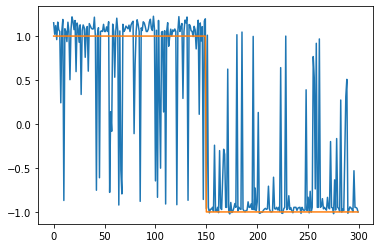

In [65]:

def SVM(K,Y,C=1.):
    N = K.shape[0]
    G = np.vstack([np.eye(N,N),-np.eye(N,N)])

    # C = 1/2/N/lmbda
    
    h = np.concatenate([np.repeat(C,N),np.repeat(0,N)]).astype(np.double)
    label = -1.*np.logical_not(Y)+1.*Y
    P = np.diag(label)@K@np.diag(label)
    np.testing.assert_array_equal(P,P.transpose())

    A = np.matrix(label)
    b = np.zeros(1)
    q = -np.ones((N,1))


    P = cvxopt_matrix(P)
    G =cvxopt_matrix(G)
    h =cvxopt_matrix(h)
    b =cvxopt_matrix(b)
    A =cvxopt_matrix(A)
    q =cvxopt_matrix(q)

    # print(f'{P=}')
    # print(f'{q=}')
    # print(f'{G=}')
    # print(f'{h=}')
    # print(f'{A=}')
    # print(f'{b=}')

    sol = cvxopt_solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b, )
    alphas = np.array(sol['x'])

    return alphas

def pred(gram,Y,alphas):
    label = -1.*np.logical_not(Y)+1.*Y
    return gram.dot(alphas*label)

C = 1

get_K = RBF_K
K = get_K(X,X)
gram = get_K(X,X)


alphas = SVM(K,Y,C = C)

S = (alphas > 1e-4).flatten()
# # b = y[S] - np.dot(X[S], w)
print('Indices of support vectors = ',np.where(S))
print('Alphas = ',alphas[alphas > 1e-4])

print('Support vectors = ', X[S])
print('Number of support vectors for each class = ', np.sum(S))

label = -1.*np.logical_not(Y)+1.*Y
alphas = np.squeeze(alphas)

y = pred(gram,Y,alphas)

plt.plot(y)
plt.plot(label)


# comparison with scikit

b =  [-0.0604037]
Indices of support vectors =  [151 158 163 166 167 168 169 171 174 177 178 179 180 185 191 192 193 194
 196 198 200 201 211 216 221 223 227 228 231 232 233 237 241 242 248 250
 252 254 255 256 257 258 259 261 264 269 272 273 276 278 282 286 287 288
 291 295 296   1   3   7   8  10  13  15  16  22  25  27  28  31  34  37
  41  42  45  48  54  55  56  57  59  60  64  66  67  69  75  79  80  85
  86  91  92 100 102 104 105 107 108 110 113 114 115 116 121 127 132 137
 140 143 144 145 147]
Support vectors =  [[-1.20450999e-02 -8.55814847e-01]
 [-9.77374950e-01  7.75175253e-01]
 [ 1.09191248e+00 -6.04965803e-01]
 [ 1.29347401e-02  3.59143882e-01]
 [-3.05583375e-01  4.69706409e-01]
 [-1.16013580e+00  9.94235320e-01]
 [-5.31002921e-01  9.12231459e-01]
 [ 3.98802639e-02 -3.66847723e-01]
 [ 2.78673242e-01  1.49554916e-01]
 [ 1.49307538e-01  4.84236346e-01]
 [ 1.13749655e-01  4.38342213e-01]
 [ 7.52040911e-01  2.88381239e+00]
 [-9.31065560e-01 -7.71588220e-01]
 [-6.02907675e-01 

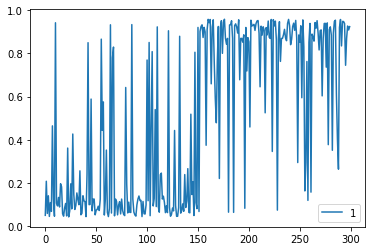

In [66]:
# for C in np.logspace(-2,2,5):

clf = svm.SVC(probability=True,C=C,kernel='rbf')
clf.fit(X, Y)
y = clf.predict_proba(X)[:,0]

plt.plot(y,label = C)
plt.legend()

print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))


In [7]:
def pred(gram,Y,alphas):
    label = -1.*np.logical_not(Y)+1.*Y
    return gram.dot(alphas*label)

def run_SVM_get_pred(K, gram,Y,C = 1, X= None, Z = None):

    alphas = SVM(K,Y,C=C)
    alphas = np.squeeze(alphas)

    label = -1.*np.logical_not(Y)+1.*Y
    alphas = np.squeeze(alphas)

    y = pred(gram,Y,alphas)

    return pred(gram,Y,alphas)


# Varying regularization param C

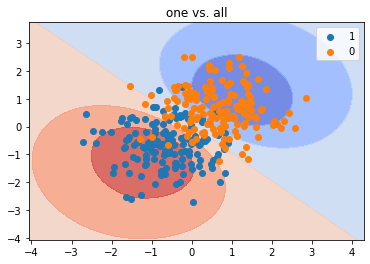

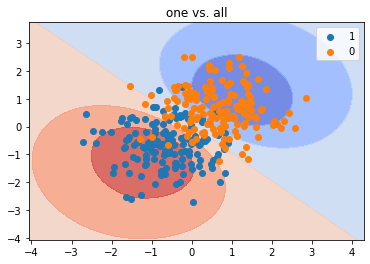

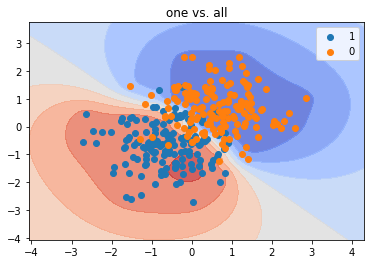

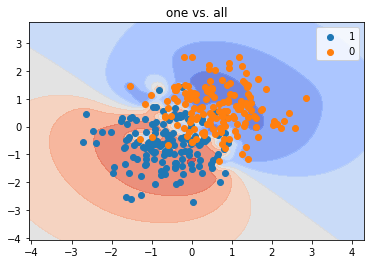

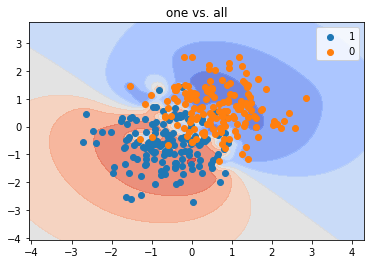

In [67]:

def run_SVM_and_plot_contours(X,Y, clf = run_SVM_get_pred, n_map = 100, C = 1, get_K = linear_K):

    x_min, x_max = np.min(X[:,0])*1.5,np.max(X[:,0])*1.5
    y_min, y_max = np.min(X[:,1])*1.5,np.max(X[:,1])*1.5

    x_r = np.linspace(x_min,x_max,n_map)
    y_r = np.linspace(y_min,y_max,n_map)
    x_r, y_r = np.meshgrid(x_r,y_r)
    x_r_, y_r_ = np.ndarray.flatten(x_r),np.ndarray.flatten( y_r)
    Z = np.vstack((x_r_,y_r_)).transpose()

    K = get_K(X,X)
    gram = get_K(Z,X)

    y = clf(K,gram,Y,C = C,X = X,Z = Z)

    plt.figure()
    plt.contourf(x_r, y_r, y.reshape(n_map,n_map), cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[Y==1,0],X[Y==1,1],label = '1')
    plt.scatter(X[Y==0,0],X[Y==0,1],label = '0')
    plt.legend()    

# generate data
N = 300
X = np.zeros((N,2))
c1, c2 = [1,1], [-1,-1]
sigma = 1.5
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

X = X-np.mean(X,axis=0)
X = X/np.std(X,axis=0)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)

for C in np.logspace(-4,4,5):
    run_SVM_and_plot_contours(X,Y,C= C, get_K =RBF_K)
    plt.title('one vs. all')
    plt.show()


# comparison with scikit
Scikit Rbf uses a method to automatically calibrate the RBF variance term

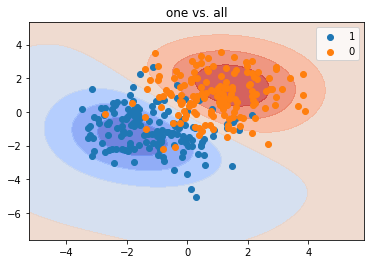

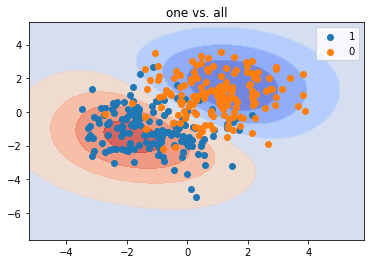

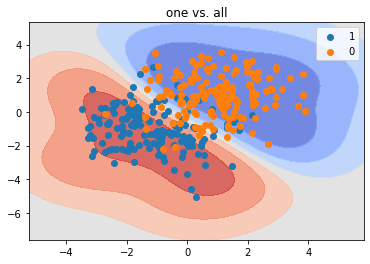

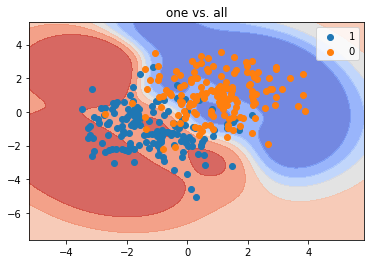

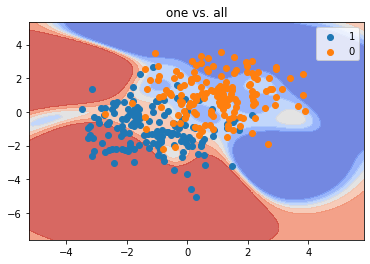

In [9]:

def scikit_SVM(K,gram,Y,C = 1,X=None,Z=None,kernel = 'rbf'):

    clf = svm.SVC(probability=True,C=C,kernel=kernel)
    clf.fit(X, np.logical_not(Y))
    y = clf.predict_proba(Z)
    return y[:,0]


for C in np.logspace(-4,4,5):
    run_SVM_and_plot_contours(X,Y,clf = scikit_SVM,C= C)
    plt.title('one vs. all')
    plt.show()



# C and $\sigma$ grid search over test data

(500, 2)


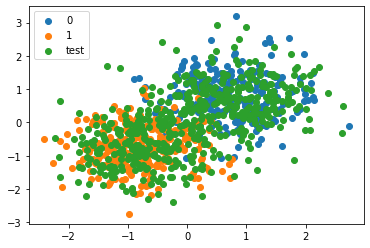

In [68]:
N = 1000
X = np.zeros((N,2))
print(np.random.multivariate_normal(c1,np.eye(2,2),N//2).shape)
mu = 2
c1, c2 = [mu,mu], [-mu,-mu]
sigma = 3
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

X = X-np.mean(X,axis=0)
X = X/np.std(X,axis=0)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)
idx = np.random.choice(range(N),N,replace=False)

split = int(N//2)
X, Y = X[idx], Y[idx]
X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:]
Y_test = Y[split:]

plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1],label = '0')
plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1],label = '1')
plt.scatter(X_test[:,0],X_test[:,1],label = 'test')
plt.legend()

In [69]:
from sklearn.metrics import log_loss

def scikit_SVM(K,gram,Y,C = 1,X=None,Z=None,kernel = 'rbf'):

    clf = svm.SVC(probability=True,C=C,kernel=kernel)
    clf.fit(X, np.logical_not(Y))
    y = clf.predict(Z)
    return np.logical_not(y)


max acc scikit :  0.944


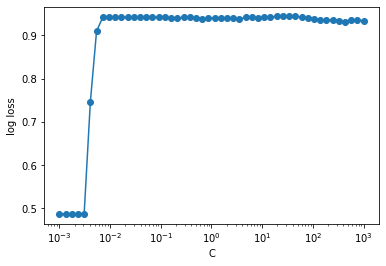

In [70]:
res = []

clf = scikit_SVM

C_list = np.logspace(-3,3,50)
sig = 1e-1
def RBF_K(A,B,RBF_sig=sig):

    D = distance_matrix(A,B)
    return np.exp(-D/2/RBF_sig**2)

get_K = RBF_K
K = get_K(X_train,X_train)
gram = get_K(X_test,X_train)


for C in C_list:
    y = clf(K,gram,Y_train, C=C,X = X_train,Z = X_test)
    # res.append(log_loss(Y_test,np.sign(y)>0))

    # res.append(log_loss(Y_test,y>0))
    res.append(np.mean(np.logical_not(np.logical_xor(Y_test,y>0))))

plt.plot(C_list,res,'o-')
plt.xscale('log')
plt.ylabel('log loss')
plt.xlabel('C')
print('max acc scikit : ',np.max(res))

max acc ours :  0.942


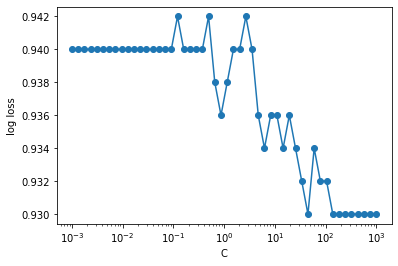

In [71]:
res = []
clf = run_SVM_get_pred

C_list = np.logspace(-3,3,50)
sig = 1
def RBF_K(A,B,RBF_sig=sig):

    D = distance_matrix(A,B)
    return np.exp(-D/2/RBF_sig**2)

get_K = RBF_K
K = get_K(X_train,X_train)
gram = get_K(X_test,X_train)


for C in C_list:
    y = clf(K,gram,Y_train, C=C,X = X_train,Z = X_test)
    # res.append(log_loss(Y_test,np.sign(y)>0))

    # res.append(log_loss(Y_test,y>0))
    res.append(np.mean(np.logical_not(np.logical_xor(Y_test,y>0))))

plt.plot(C_list,res,'o-')
plt.xscale('log')
plt.ylabel('log loss')
plt.xlabel('C')
print('max acc ours : ',np.max(res))

max acc ours :  0.942


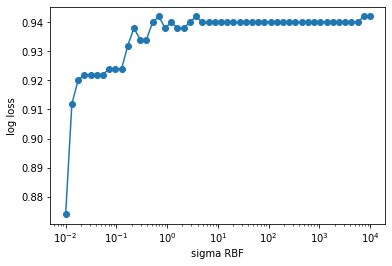

In [72]:
res = []
clf = run_SVM_get_pred
C = 1
sig_list = np.logspace(-2,4,50)
for sig in sig_list:

    def RBF_K(A,B,RBF_sig=sig):

        D = distance_matrix(A,B)
        return np.exp(-D/2/RBF_sig**2)
    get_K = RBF_K

    K = get_K(X_train,X_train)
    gram = get_K(X_test,X_train)

    y = clf(K,gram,Y_train, C=C,X = X_train,Z = X_test)
    # res.append(log_loss(Y_test,np.sign(y)>0))

    # res.append(log_loss(Y_test,y>0))
    res.append(np.mean(np.logical_not(np.logical_xor(Y_test,y>0))))
plt.plot(sig_list,res,'o-')
plt.xscale('log')
plt.ylabel('log loss')
plt.xlabel('sigma RBF')

print('max acc ours : ',np.max(res))